# Red Neuronal

### Librerías

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import math
from collections import Counter
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.optimizers import Adagrad, Adam, SGD, Nadam, RMSprop, Adadelta
from tensorflow.keras.callbacks import EarlyStopping

### Procesamiento del Dataset

In [4]:
# Cargar dataset
df = pd.read_csv('../pwlds_full.csv')
df['Password'] = df['Password'].astype(str).fillna('')

def compute_entropy(pw):
    if not pw:
        return 0
    counts = Counter(pw)
    length = len(pw)
    entropy = -sum((count / length) * math.log2(count / length) for count in counts.values())
    return entropy

# Función para extraer características
def extract_features(pw):
    length = len(pw)
    num_digits = sum(c.isdigit() for c in pw)
    num_lowercase = sum(c.islower() for c in pw)
    num_uppercase = sum(c.isupper() for c in pw)
    num_special_chars = sum(not c.isalnum() for c in pw)
    
    char_count = {}
    max_consecutive_chars = 1
    current_streak = 1
    char_type_changes = 0
    prev_type = None

    for i, c in enumerate(pw):
        # Caracter repetido
        char_count[c] = char_count.get(c, 0) + 1

        # Consecutivos
        if i > 0 and pw[i] == pw[i-1]:
            current_streak += 1
            max_consecutive_chars = max(max_consecutive_chars, current_streak)
        else:
            current_streak = 1

        # Tipo de carácter
        if c.isdigit():
            t = 'digit'
        elif c.islower():
            t = 'lower'
        elif c.isupper():
            t = 'upper'
        else:
            t = 'special'

        if prev_type and t != prev_type:
            char_type_changes += 1
        prev_type = t

    char_repea = sum(count - 1 for count in char_count.values() if count > 1)
    entropy = compute_entropy(pw)

    return [
        length, num_digits, num_lowercase, num_uppercase, num_special_chars,
        char_repea, max_consecutive_chars, char_type_changes, entropy
    ]




### Extraer características y etiquetas

In [5]:
X = np.array([extract_features(pw) for pw in df['Password']])
y = df['Strength_Level'].astype(int)

print("Valores únicos en y:", np.unique(y))
print(df['Strength_Level'].value_counts().sort_index())

Valores únicos en y: [0 1 2 3 4]
Strength_Level
0    2000043
1    2000021
2    2000024
3    2000382
4    2000000
Name: count, dtype: int64


### Normalizar datos

In [6]:
# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Guardar el Scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

### Segmentación de los datos

In [7]:
# One-hot encoding de las clases
y_cat = to_categorical(y, num_classes=5)

# Dividir en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_cat, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Pruebas:", X_test.shape, y_test.shape)

Entrenamiento: (7000329, 9) (7000329, 5)
Validación: (1500070, 9) (1500070, 5)
Pruebas: (1500071, 9) (1500071, 5)


### ---

### Construcción del modelo

In [11]:
#Parámetros
tasa_aprendizaje = 0.001
numero_epocas = 100 
lote = 32

#optimizador = SGD(learning_rate=tasa_aprendizaje)
optimizador = Adam(learning_rate=tasa_aprendizaje)
#optimizador = Adagrad(learning_rate=tasa_aprendizaje)
#optimizador = Nadam(learning_rate=tasa_aprendizaje)
#optimizador = RMSprop(learning_rate=tasa_aprendizaje)
#optimizador = Adadelta(learning_rate=tasa_aprendizaje)

model = Sequential()

#Capa de entrada
model.add(Dense(units=128, activation="relu", input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

#Capas densas
model.add(Dense(units=64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

#Capa de Salida
model.add(Dense(units=5, activation="softmax"))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,677 (49.52 KB)

 Trainable params: 12,229 (47.77 KB)

 Non-trainable params: 448 (1.75 KB)

### Compilación del modelo

In [12]:
model.compile(
    optimizer=optimizador,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Entrenamiento del modelo

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=numero_epocas,
    batch_size=lote,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/100
218761/218761 ━━━━━━━━━━━━━━━━━━━━ 220s 998us/step - accuracy: 0.9295 - loss: 0.1782 - val_accuracy: 0.9532 - val_loss: 0.1128
Epoch 2/100
218761/218761 ━━━━━━━━━━━━━━━━━━━━ 251s 1ms/step - accuracy: 0.9444 - loss: 0.1398 - val_accuracy: 0.9529 - val_loss: 0.1135
Epoch 3/100
218761/218761 ━━━━━━━━━━━━━━━━━━━━ 225s 1ms/step - accuracy: 0.9453 - loss: 0.1369 - val_accuracy: 0.9536 - val_loss: 0.1125
Epoch 4/100
218761/218761 ━━━━━━━━━━━━━━━━━━━━ 250s 1ms/step - accuracy: 0.9460 - loss: 0.1354 - val_accuracy: 0.9534 - val_loss: 0.1120
Epoch 5/100
218761/218761 ━━━━━━━━━━━━━━━━━━━━ 251s 1ms/step - accuracy: 0.9463 - loss: 0.1346 - val_accuracy: 0.9533 - val_loss: 0.1137
Epoch 6/100
218761/218761 ━━━━━━━━━━━━━━━━━━━━ 250s 1ms/step - accuracy: 0.9465 - loss: 0.1339 - val_accuracy: 0.9543 - val_loss: 0.1124
Epoch 7/100
218761/218761 ━━━━━━━━━━━━━━━━━━━━ 250s 1ms/step - accuracy: 0.9469 - loss: 0.1331 - val_accuracy: 0.9537 - val_loss: 0.1117
Epoch 8/100
218761/218761 ━━━━━━━━━━━━━

### Evaluar el modelo

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Precisión en conjunto de prueba: {test_acc:.4f}')

Precisión en conjunto de prueba: 0.9546


### Guardar el modelo

In [17]:
#guardar los datos
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

#guardar el historial
import json

with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Guardar el modelo
model.save('classifier_model.h5')

### Cargar el modelo

In [2]:
import json
import pickle
import numpy as np
from tensorflow.keras.models import load_model

def load_trained_model():
    model = load_model("classifier_model.h5")

    with open('history.json', 'r') as f:
        history = json.load(f)

    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    return model, history, scaler

model, history, scaler = load_trained_model()

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

### Metricas

In [3]:
#Evaluar modelo
y_pred = np.argmax(model.predict(X_test), axis=1)

if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

46878/46878 ━━━━━━━━━━━━━━━━━━━━ 25s 538us/step


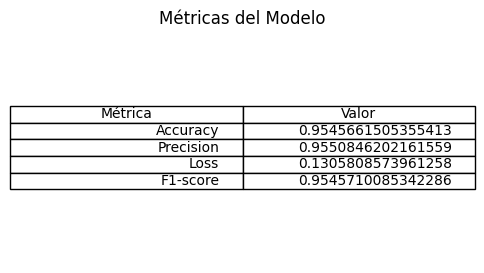

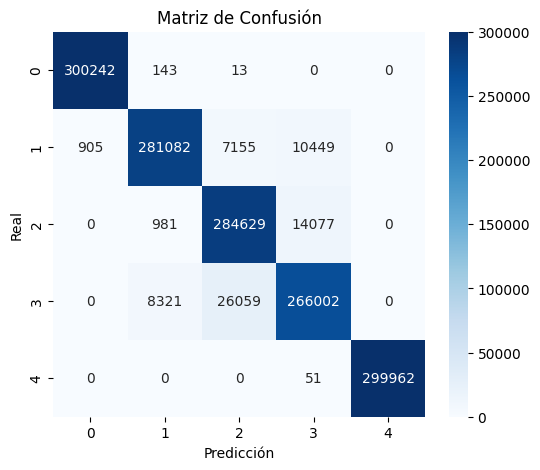

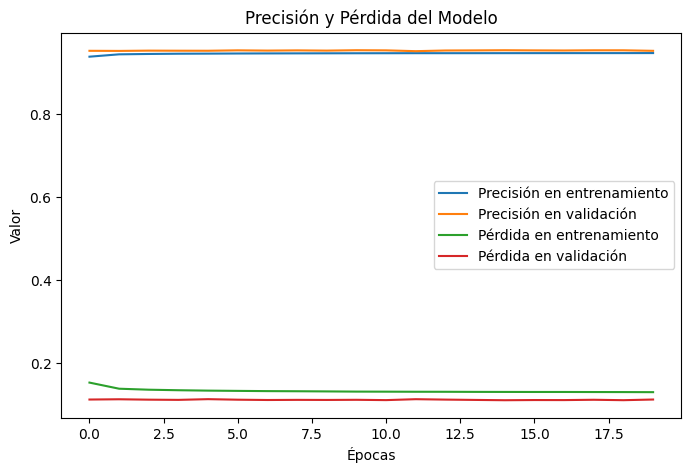

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluar_modelo():
    report = classification_report(y_test_labels, y_pred, output_dict=True)
    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Loss", "F1-score"],
        "Valor": [report["accuracy"], report["weighted avg"]["precision"], history["loss"][-1], report["weighted avg"]["f1-score"]]
    })
    
    # Mostrar tabla de métricas
    plt.figure(figsize=(6, 3))
    plt.axis('tight')
    plt.axis('off')
    plt.table(cellText=metrics_table.values, colLabels=metrics_table.columns, loc='center')
    plt.title("Métricas del Modelo")
    plt.show()
    
    # Matriz de confusión
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test_labels, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()
    
    # Gráfica de precisión y pérdida
    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'], label='Precisión en entrenamiento')
    plt.plot(history['val_accuracy'], label='Precisión en validación')
    plt.plot(history['loss'], label='Pérdida en entrenamiento')
    plt.plot(history['val_loss'], label='Pérdida en validación')
    plt.xlabel("Épocas")
    plt.ylabel("Valor")
    plt.legend()
    plt.title("Precisión y Pérdida del Modelo")
    plt.show()

evaluar_modelo()

### Comparar con contraseñas filtradas

In [23]:
def is_common_password(password):
    with open("../rockyou.txt", encoding="latin-1")as f:
        for line in f:
            if password == line.strip():
                return True
        
        return False
    return 0

### Pruebas unitarias

In [28]:
def analyze_password(password):
    labels = ['Vulnerable','Débil', 'Media', 'Fuerte', 'Muy fuerte']
    features = extract_features(password)
    
    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)
    prediction = model.predict(features)
    strength_level = np.argmax(prediction)
    
    print(password)
    print(f"Nivel de seguridad de la contraseña: {labels[strength_level]}")
    if is_common_password(password):
        print("Esta es una contraseña común, se recomienda cambiarla")

password_to_check = input("Enter a password: ")
analyze_password(password_to_check)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
68s4dfsd
Nivel de seguridad de la contraseña: Débil


# Estructura del Modelo

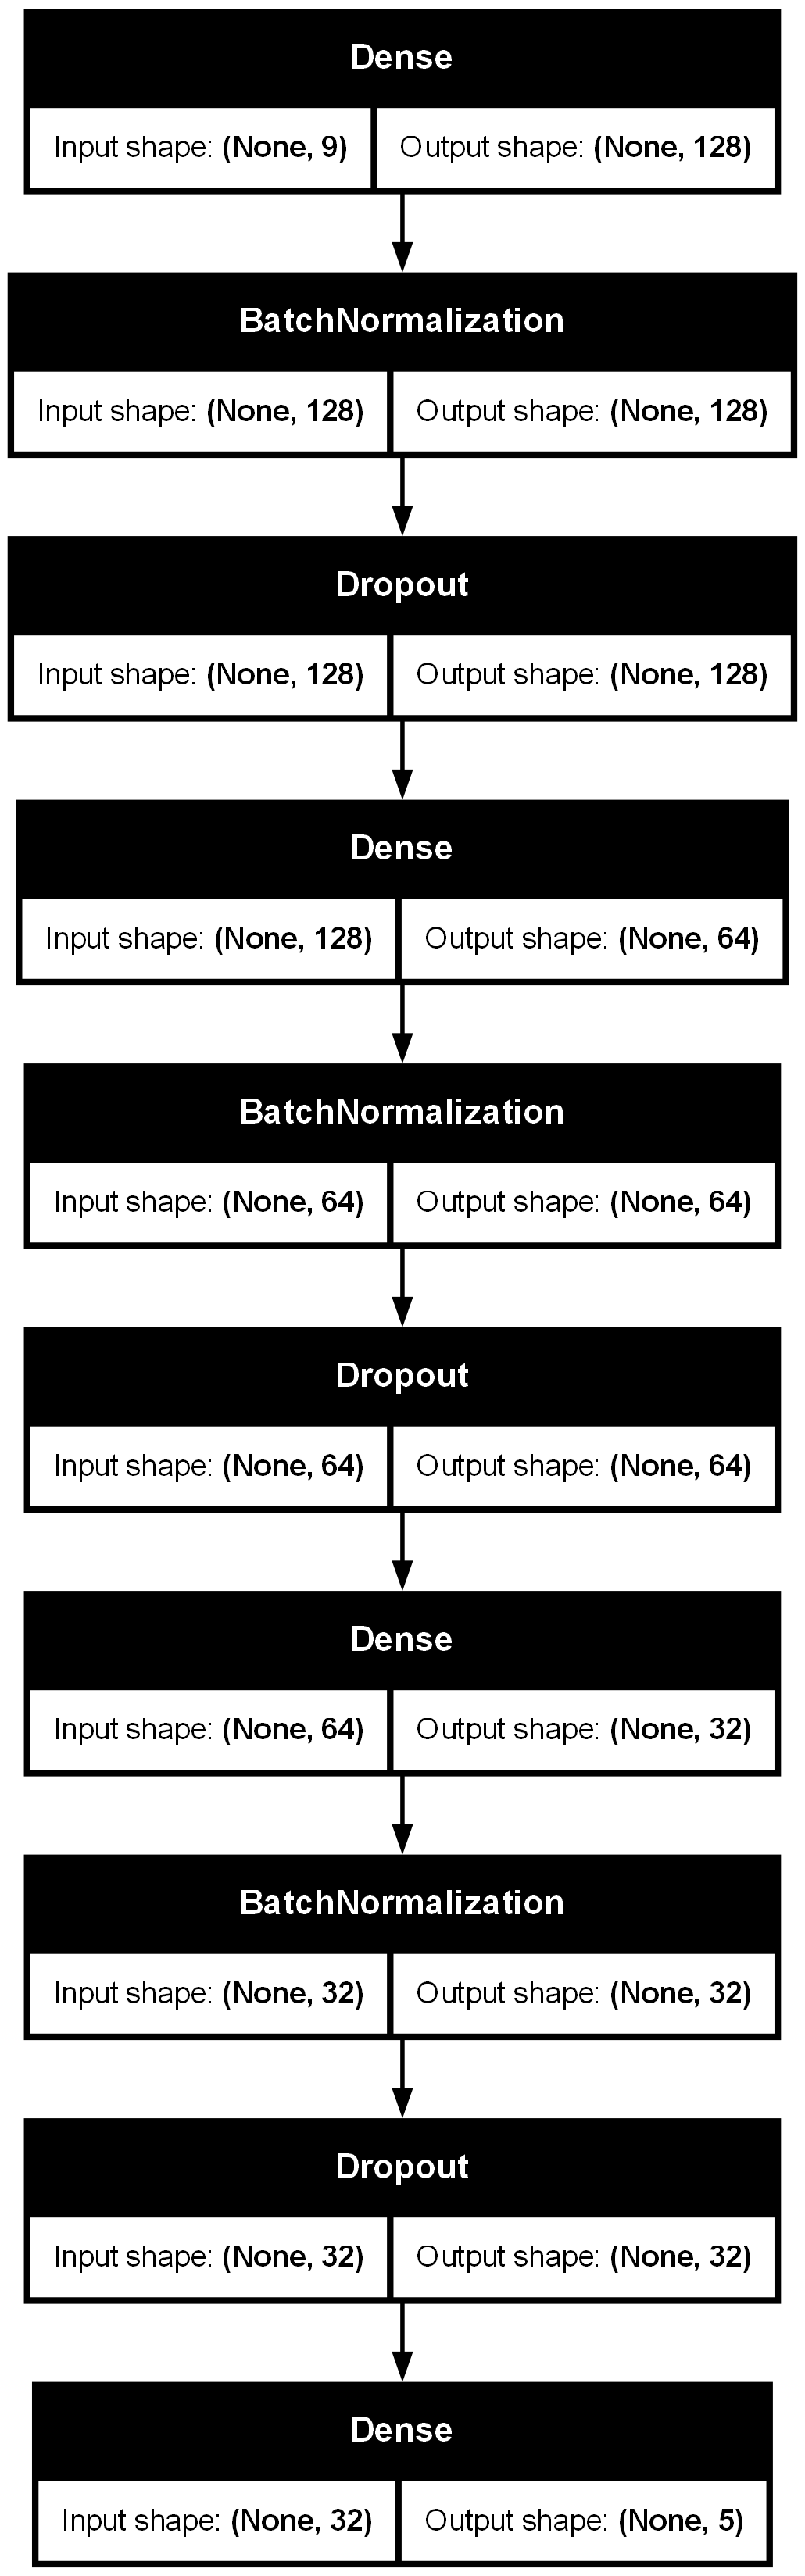

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)